In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')
from bs4 import BeautifulSoup
import requests
import datetime, time

#importing essential libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
# %matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

In [254]:
start_date = '20150901'
# end_date = '20191101'
end_date = time.strftime("%Y%m%d")

In [255]:
url ="https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=" + start_date + "&end=" + end_date
example_df = pd.read_html(url)

data = example_df[2]
df =pd.DataFrame(data)

df['Date'] =  pd.to_datetime(df['Date']) # date
df.columns = ['Date','Open','High','Low','Close','Volume','Market Cap']
df.set_index('Date',inplace=True)
df.sort_index(inplace=True)

df['return'] = df['Close'].pct_change(1)
df['vola'] = df['return'].rolling(15).std()*(360**0.5)*100

In [256]:
# df.vola.plot(figsize=(12, 7));

Text(0, 0.5, 'Price')

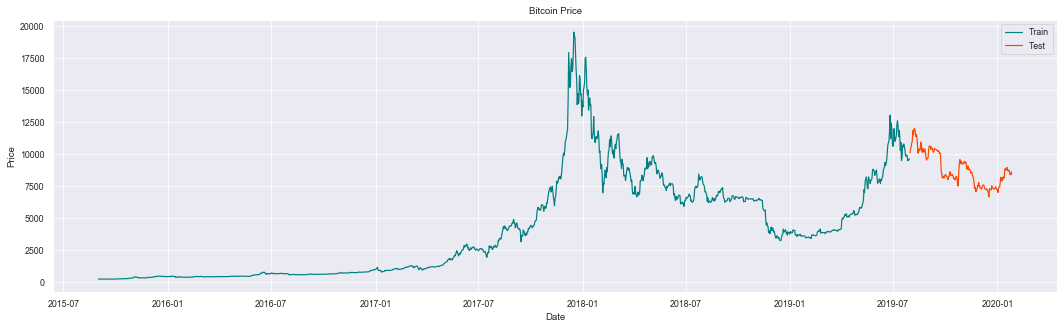

In [257]:
days = 180
train = df.iloc[:-days,[3]].copy()
test = df.iloc[-days:,[3]].copy()
plt.figure(figsize=(18,5))
plt.title('Bitcoin Price')
plt.plot(train['Close'], color='teal')
plt.plot(test['Close'], color='orangered')
plt.legend(['Train','Test'])
plt.xlabel('Date')
plt.ylabel('Price')
# plt.show()

In [258]:
#creating a function to plot the graph and show the test result:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Bitcoin Price')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Price Distribution')

    plt.tight_layout()
    
    print('Dickey-Fuller test results:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Statistical Test','P-Value','Used Lags','Observations Number'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Values (%s)"%key] = value.round(4)
        
    print(adftest)

Dickey-Fuller test results:
Statistical Test           -1.8316
P-Value                     0.3649
Used Lags                  20.0000
Observations Number      1408.0000
Critical Values (1%)       -3.4350
Critical Values (5%)       -2.8636
Critical Values (10%)      -2.5679
dtype: float64


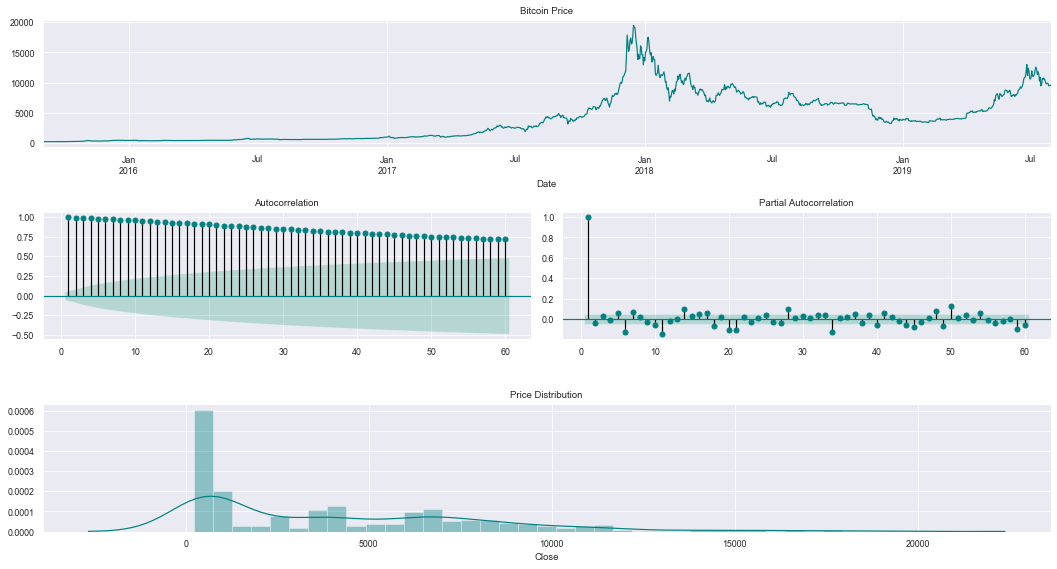

In [259]:
check_stationarity(train['Close'], lags_plots=60)

Dickey-Fuller test results:
Statistical Test           -7.0208
P-Value                     0.0000
Used Lags                  19.0000
Observations Number      1408.0000
Critical Values (1%)       -3.4350
Critical Values (5%)       -2.8636
Critical Values (10%)      -2.5679
dtype: float64


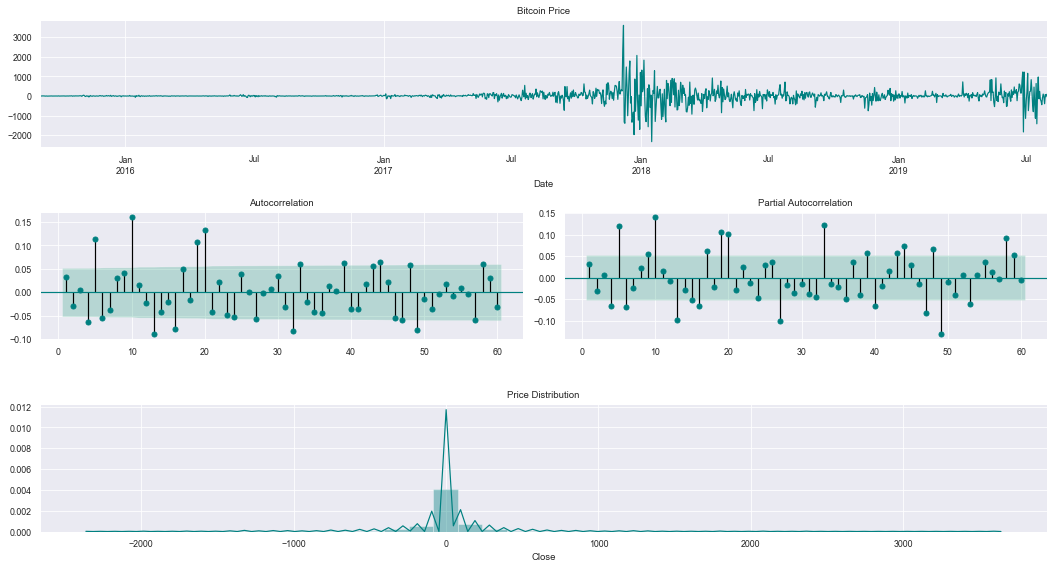

In [260]:
check_stationarity(train['Close'].diff().dropna(), lags_plots=60)

In [261]:
# Training the model
model = ARIMA(train, order=(3,1,0)).fit()
train_pred = model.predict()

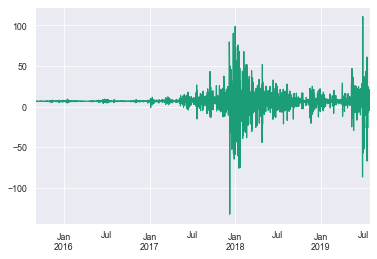

In [262]:
train_pred.plot()

In [263]:
# Prediction base with one diferencing
train_pred[:5]

2015-09-02    6.568139
2015-09-03    6.394647
2015-09-04    6.445740
2015-09-05    6.684066
2015-09-06    6.557092
Freq: D, dtype: float64

In [264]:
# Returning the price to BRL/bags
train_pred[0] += train.iloc[0,0]
train_pred = np.cumsum(train_pred)
train_pred.head()

2015-09-02    234.688139
2015-09-03    241.082786
2015-09-04    247.528526
2015-09-05    254.212592
2015-09-06    260.769684
Freq: D, dtype: float64

In [265]:
train['Price Pred'] = train_pred
train.dropna(inplace=True)
train.tail()

,Close,Price Pred
Date,,
2019-07-26,9870.30,9587.068550
2019-07-27,9477.68,9588.580306
2019-07-28,9552.86,9583.938914
2019-07-29,9519.15,9604.680191
2019-07-30,9607.42,9605.281722


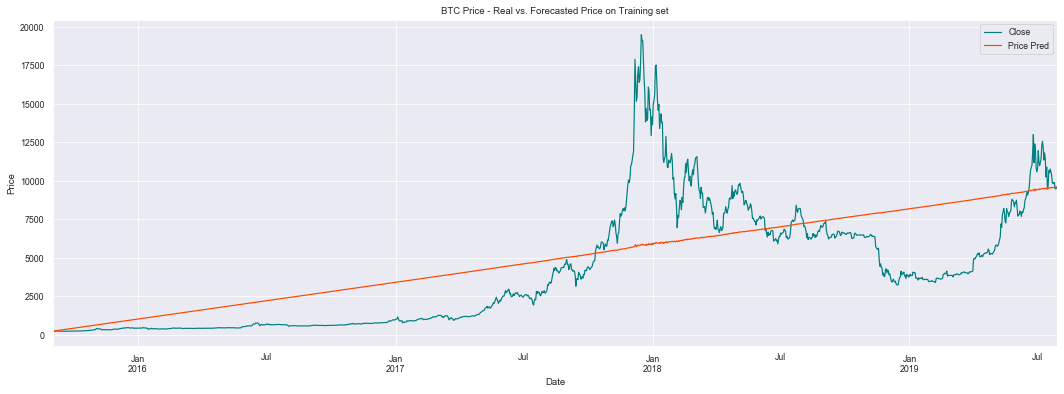

In [266]:
# Plotting the graph
train.plot(figsize=(18,6), 
            title='BTC Price - Real vs. Forecasted Price on Training set',
           color=['Teal','orangered'])
plt.ylabel('Price')
plt.show()

In [267]:
# Measuring Training Error by Root Mean Squared Error
from sklearn.metrics import mean_squared_error
error = sqrt(mean_squared_error(train['Close'], train['Price Pred']))
print(f'The RMSE was BRL {round(error,4)}/bag')

The RMSE was BRL 2873.7735/bag


In [268]:
# Taking the constant and the coefficients of the lags to use in the test base:
const, l1, l2, l3 = model.params

print(f'Constant value {round(const, 4)}')
print(f'Cofficients of Lag 1: {round(l1,4)}, Lag 2: {round(l2,4)} and Lag 3: {round(l3,4)}')

Constant value 6.5681
Cofficients of Lag 1: 0.0332, Lag 2: -0.0306 and Lag 3: 0.0063


In [269]:
def predict_n_steps(train, test, steps):
    
    # # Adding differenced series to create a forecast
    diff_train = train.diff().dropna().values
    hist = [x for x in diff_train]

    diff_test = test.diff().dropna().values
    diff_test = [x for x in diff_test]

    # Adding the first differenced value in the test set that was between the training and test set
    first_diff = train[-1] - test[0]
    diff_test.insert(0, first_diff)
    
    pred = []

    for i in range(0,len(test), steps):
        for j in range(steps):
    
            yhat = const + (l1 * hist[-1]) + (l2 * hist[-2]) + (l3 * hist[-3])
            pred.append(yhat)
            # using the current forecast as the basis for new forecasts
            hist.append(yhat)
        obs = diff_test[i:i+steps]
        hist = list(np.append(hist,obs))
    return pred

In [270]:
# Testing the function
steps = 5
pred = predict_n_steps(train['Close'], test['Close'], steps=steps)
print('Predictions before reverting the diferentiation: ')
print(pred[:5])

Predictions before reverting the diferentiation: 
[11.009435018833276, 4.023339827935163, 6.9251955766178215, 6.745247322735795, 6.606302813604268]


In [271]:
def inverse_diff(train, test, prediction, steps):
    '''
    Using the last day of the training base, after that, I use the last 4 forecasted values as basis, recurrently until
    the end of the series
    '''
    train = [x for x in train]
    test = [x for x in test]
    inverted_pred = []
    
    for i in range(0,len(test), steps): 
        invert = train[-1] + prediction[i]
        inverted_pred.append(invert)
        
        for j in range(steps-1):
            invert += prediction[i+j+1]
            inverted_pred.append(invert)
        train = np.append(train, test[i:i+steps])
    return inverted_pred

In [272]:
# Adding the forecast in the test set to compare later
test['Price Pred'] = inverse_diff(train['Close'],
                                    test['Close'],
                                    pred, steps=steps)

In [273]:
def plot_comparative(orig, pred, steps, title='', figsize=(18,8)):
    plt.figure(figsize=figsize)
    
    orig = np.array(orig)
    pred = np.array(pred)
    plt.plot(orig, color='teal')
    
    for i in range(0,len(orig), steps):
        x_axis = [x for x in range(i,i+steps)]
        plt.plot(x_axis, pred[i:i+steps], color='orangered')
    
    plt.title(title, fontsize=12)
    plt.ylabel('Prices')
    plt.legend(('Original', 'Prediction'))
    plt.show()

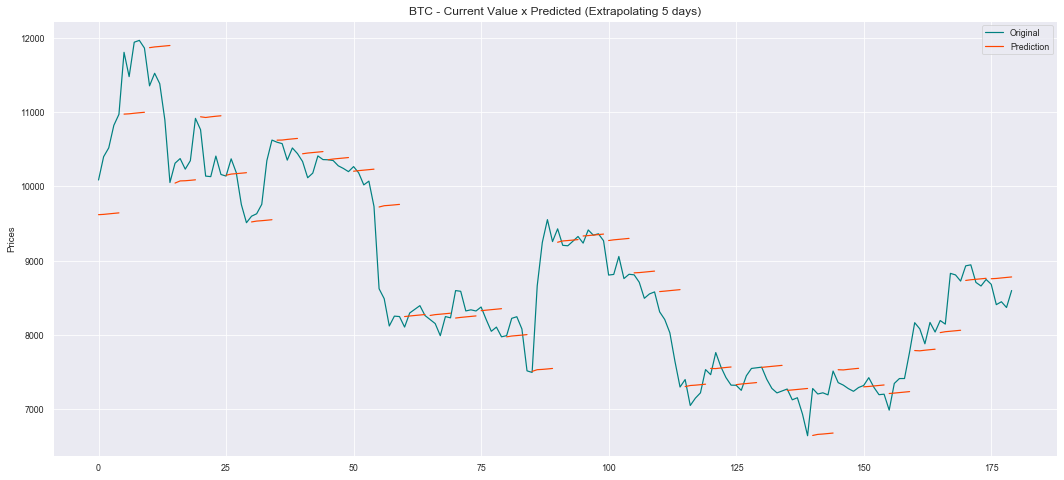

In [274]:
plot_comparative(test['Close'], test['Price Pred'], steps=steps, 
                   title='BTC - Current Value x Predicted (Extrapolating 5 days)')

In [245]:
test_error = sqrt(mean_squared_error(test['Close'], test['Price Pred']))
print(f'The RMSE on the test set was BRL {round(test_error,4)}/bag')

The RMSE on the test set was BRL 543.576/bag


In [246]:
def n_steps_error(orig, pred, steps, plot=True):
    # Calculating the RMSE on each step
    error = ((np.array(orig) - np.array(pred))**2)**(1/2)
    
    # Changing the shape to become: (examples, steps)
    error = error.reshape(int(len(error)/steps), steps)
    
    # Calculating the mean error on each step
    mean = error.mean(axis=0)
    
    # Plotting the error graph
    if plot:
        index = np.arange(0,steps)
        plt.figure(figsize=(12,4))
        plt.plot(mean, 'o-', color='teal', markersize=8)
        plt.title('RMSE for each step', fontsize=15)
        plt.xlabel('Steps', fontsize=15)
        plt.ylabel('Error', fontsize=15)
        for x, y in zip(index, mean):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x, y), xytext=(x-0.1, y+.075), fontsize=12)
        plt.xticks(np.arange(steps), [x for x in range(1,steps+1)])
        plt.yticks([x for x in np.linspace(min(mean)-0.2, max(mean)+0.2, 10)])
        plt.grid(axis='y')
        plt.show()
    print(f'The RMSE for each step is: \n{mean}')

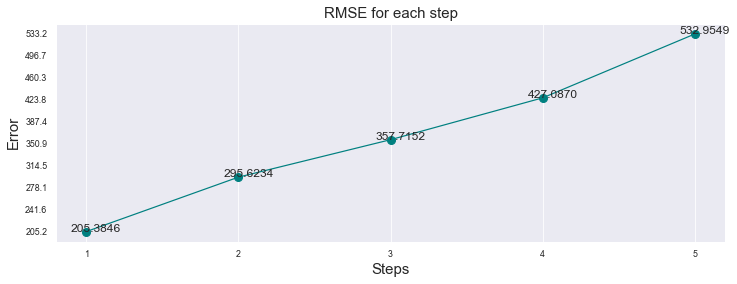

The RMSE for each step is: 
[205.38463005 295.6233965  357.71520156 427.08697847 532.95491949]


In [247]:
error_steps = n_steps_error(test['Close'], test['Price Pred'], steps)
error_steps

In [248]:
# %matplotlib notebook
# plt.style.use('ggplot')

# steps = 5
# x_axis_pred = []
# x_axis_orig = [x for x in range(len(test))]
# yhat = []
# pred = np.array([x for x in test['Price Pred']])
# base = [x for x in test['Close']]

# for i in range(0,len(test), steps):
#     x_axis_pred.append([x for x in range(i,i+steps)])
#     yhat.append([x for x in pred[i:i+steps]])

# # Criando a base dos gráficos
# fig = plt.figure(figsize=(10.5,5))
# plt.axis([0, len(base), min(base)-2.5,max(base)+2.5])

# def animate(i):
    
#     plt.plot(x_axis_pred[i], yhat[i], c='orangered')
#     plt.plot(x_axis_orig[:i*steps], base[:i*steps], c='teal')
# plt.xlabel('Interval', fontsize=12)
# plt.ylabel('Price', fontsize=15)
# plt.title('BTC Price Comparative - Real x Predicted', fontsize=15)
# plt.axis([0, len(base), min(base)-1.5 ,max(base)+1.5])

# ani = FuncAnimation(fig, animate, frames=50, interval=250)
# # ani.save('comparative.gif', writer='pillow')
# plt.show()